# Paso 1. Abrir el archivo y observar la información general.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from math import factorial
from scipy import stats as st
import math as mt
from scipy.stats import levene

df = pd.read_csv("/datasets/games.csv")

df.info()
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


# Paso 2. Preparar los datos y mostrarlos.

In [2]:
# Reemplaza los nombres de las columnas, columna "name","platform" y "genre" (ponlos en minúsculas).
df.columns = df.columns.str.lower()
df["name"] = df["name"].str.lower()
df["platform"] = df["platform"].str.lower()
df["genre"] = df["genre"].str.lower()

# Al agrupar los datos por plataformas, hay algunas consolas que no tienen una cantidad significativa de 
# ventas totales, por ejemplo 3do, gg, ng, pcfx, tg16, scd y ws. Las voy a eliminar ya que no son relevantes 
# para este estudio. 
df = df[~df["platform"].isin(["3do","gg","ng","pcfx","tg16","scd","ws"])]

In [3]:
# Datos ausentes y otras correcciones de cada columna.
    # Columna "name". Hay 2 títulos de juegos que están como ausentes, voy a sustituirlos como "unknown"
df["name"] = df["name"].fillna("unknown")

    # Columna "platform", en esta columna hay una consola llamada 2600, para evitar confusiones de que haya 
    # algún error de que se trata de un número, voy a sustituirlo por atari, que es el otro nombre de la 
    # consola.
df["platform"] = df["platform"].replace("2600","atari")

    # Columna "year_of_release". Hay 269 valores ausentes, voy a obtener la mediana de los años en los que 
    # cada consola estuvo lanzando juegos, así los títulos que no tienen año tendrán un año de lanzamiento
    # erroneo tal vez, pero estará dentro del rango de años en los que cada consola estuvo lanzando juegos.
    
platforms = df["platform"].unique().tolist()
grupo = df.groupby(by="platform")["year_of_release"].median()
df["year_of_release"] = df["year_of_release"].fillna("na")

for platform in platforms:
    mask = (df["platform"]==platform) & (df["year_of_release"]=="na")
    df.loc[mask,"year_of_release"] = grupo.loc[platform]

df["year_of_release"] = df["year_of_release"].astype(int)

    # Columna "genre". Hay 2 valores ausentes, al buscar que títulos son aparecen con el nombre de 
    # unknown, por lo cual para este estudio no son datos relevantes asi que se pueden eliminar. 
df = df.dropna(subset=["genre"])

    # Columnas "critic_score" y "user_score". Para tener una misma escala de puntuación entre la columna 
    # critic_score y user_score, voy a divir los valores entre 10. Si se busca la mediana y la media de
    # las columnas critic_score y user_score ambas columnas tienen valores muy similares, voy a asignar 
    # la media a los valores ausentes. Los valores definidos como "tbd" los definire como ausentes 
    # y después sustituirlos por la media.
df["critic_score"] = df["critic_score"] / 10
df["critic_score"] = df["critic_score"].fillna(df["critic_score"].mean())
df["user_score"] = df["user_score"].replace("tbd",np.nan)
df["user_score"] = df["user_score"].astype(float)
df["user_score"] = df["user_score"].fillna(df["user_score"].mean())

        # Columna "rating". La clasificación ESRB se inventó en 1994, por lo cual ningún juego antes de 
        # este año tendría una clasificación dada por este rating, el resto de juegos podría definirse como
        # NR (not ranked) o unknown.  
df["rating"] = df["rating"].fillna("NR")

        # Columna "total_sales". Voy a crear una columna nueva con las ventas totales de cada videojuego.
df["total_sales"] = df["na_sales"] + df["eu_sales"] + df["jp_sales"] + df["other_sales"]

In [4]:
df.info()
display(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16682 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16682 non-null  object 
 1   platform         16682 non-null  object 
 2   year_of_release  16682 non-null  int64  
 3   genre            16682 non-null  object 
 4   na_sales         16682 non-null  float64
 5   eu_sales         16682 non-null  float64
 6   jp_sales         16682 non-null  float64
 7   other_sales      16682 non-null  float64
 8   critic_score     16682 non-null  float64
 9   user_score       16682 non-null  float64
 10  rating           16682 non-null  object 
 11  total_sales      16682 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.7+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,7.600000,8.000000,E,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,6.896768,7.125046,NR,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,8.200000,8.300000,E,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,8.000000,8.000000,E,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,6.896768,7.125046,NR,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,samurai warriors: sanada maru,ps3,2016,action,0.00,0.00,0.01,0.00,6.896768,7.125046,NR,0.01
16711,lma manager 2007,x360,2006,sports,0.00,0.01,0.00,0.00,6.896768,7.125046,NR,0.01
16712,haitaka no psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,6.896768,7.125046,NR,0.01
16713,spirits & spells,gba,2003,platform,0.01,0.00,0.00,0.00,6.896768,7.125046,NR,0.01


# Paso 3. Analizar los datos.

Mira cuántos juegos fueron lanzados en diferentes años. ¿Son significativos los datos de cada período?

In [5]:
for platform in platforms:
    print(f'La consola {platform} lanzó juegos desde {df["year_of_release"][df["platform"]==platform].min()} hasta {df["year_of_release"][df["platform"]==platform].max()}')

La consola wii lanzó juegos desde 2006 hasta 2016
La consola nes lanzó juegos desde 1983 hasta 1994
La consola gb lanzó juegos desde 1988 hasta 2001
La consola ds lanzó juegos desde 1985 hasta 2013
La consola x360 lanzó juegos desde 2005 hasta 2016
La consola ps3 lanzó juegos desde 2006 hasta 2016
La consola ps2 lanzó juegos desde 2000 hasta 2011
La consola snes lanzó juegos desde 1990 hasta 1999
La consola gba lanzó juegos desde 2000 hasta 2007
La consola ps4 lanzó juegos desde 2013 hasta 2016
La consola 3ds lanzó juegos desde 2011 hasta 2016
La consola n64 lanzó juegos desde 1996 hasta 2002
La consola ps lanzó juegos desde 1994 hasta 2003
La consola xb lanzó juegos desde 2000 hasta 2008
La consola pc lanzó juegos desde 1985 hasta 2016
La consola atari lanzó juegos desde 1980 hasta 1989
La consola psp lanzó juegos desde 2004 hasta 2015
La consola xone lanzó juegos desde 2013 hasta 2016
La consola wiiu lanzó juegos desde 2012 hasta 2016
La consola gc lanzó juegos desde 2001 hasta 2007


Observa cómo varían las ventas de una plataforma a otra. Elige las plataformas con las mayores ventas totales y construye una distribución basada en los datos de cada año.

In [6]:
# las 5 mayores consolas con ventas totales son: Playstation 2, Xbox 360, Playstation 3, Nintendo Wii y Nintendo DS.
ventas = df.groupby(by="platform")["total_sales"].sum()
print(ventas.sort_values(ascending=False).head())

platform
ps2     1255.77
x360     971.42
ps3      939.65
wii      907.51
ds       806.12
Name: total_sales, dtype: float64


In [7]:
dist_platf_per_year = df.groupby(by=["platform","year_of_release"])["total_sales"].sum().reset_index()
dist_platf_per_year = dist_platf_per_year.merge(ventas,on="platform",how="left")
dist_platf_per_year["distribution"] = dist_platf_per_year["total_sales_x"] / dist_platf_per_year["total_sales_y"]
print(dist_platf_per_year[dist_platf_per_year["platform"]=="ps2"])
print(dist_platf_per_year[dist_platf_per_year["platform"]=="x360"])
print(dist_platf_per_year[dist_platf_per_year["platform"]=="ps3"])
print(dist_platf_per_year[dist_platf_per_year["platform"]=="wii"])
print(dist_platf_per_year[dist_platf_per_year["platform"]=="ds"])

    platform  year_of_release  total_sales_x  total_sales_y  distribution
122      ps2             2000          39.17        1255.77      0.031192
123      ps2             2001         166.43        1255.77      0.132532
124      ps2             2002         205.38        1255.77      0.163549
125      ps2             2003         184.31        1255.77      0.146771
126      ps2             2004         211.81        1255.77      0.168669
127      ps2             2005         182.87        1255.77      0.145624
128      ps2             2006         103.42        1255.77      0.082356
129      ps2             2007          75.99        1255.77      0.060513
130      ps2             2008          53.90        1255.77      0.042922
131      ps2             2009          26.40        1255.77      0.021023
132      ps2             2010           5.64        1255.77      0.004491
133      ps2             2011           0.45        1255.77      0.000358
    platform  year_of_release  total_s

Busca las plataformas que solían ser populares pero que ahora no tienen ventas. ¿Cuánto tardan generalmente las nuevas plataformas en aparecer y las antiguas en desaparecer?

**Con la distribución anterior podemos observar que las consolas con mas ventas en todos los tiempos duran en promedio con ventas muy altas por un tiempo aproximado de 5 a 6 años, después sus ventas bajan de manera considerable. Esto es debido a que en promedio las desarrolladoras de consolas como Nintendo, Playstation y Microsoft en promedio sacan una consola nueva cada 6 años. Por esto es que las ventas de cada consola bajan de manera considerable.**

**También algo que hay que considerar es que muchas veces el primer año de lanzamiento de una nueva consola pueden suceder 2 cosas, la gente espera uno o dos años para que los precios de las consolas bajen o porque a veces las consolas los primeros años pueden presentar error o fallas de fábrica. Por lo cual las personas suelen esperar un tiempo para asegurar que las consolas ya no presentan fallas continuamente.**

Determina para qué período debes tomar datos. Para hacerlo mira tus respuestas a las preguntas anteriores. Los datos deberían permitirte construir un modelo para 2017.

**Basados en la distribución de las consolas más populares, podemos tomar todos los juegos de todas las consolas que tengan una distribución mayor a 0.1. Que son los años en los que fueron más populares, ya sea por novedad o porque tuvieron juegos muy exitosos en esos años.**

Trabaja solo con los datos que consideras relevantes. Ignora los datos de años anteriores.
¿Qué plataformas son líderes en ventas? ¿Cuáles crecen y cuáles se reducen? Elige varias plataformas potencialmente rentables.

In [8]:
top_platforms = ["ps2","x360","ps3","wii","ds"]
for platform in top_platforms:
    print(dist_platf_per_year[(dist_platf_per_year["platform"]==platform) & (dist_platf_per_year["distribution"] > 0.1)])

    platform  year_of_release  total_sales_x  total_sales_y  distribution
123      ps2             2001         166.43        1255.77      0.132532
124      ps2             2002         205.38        1255.77      0.163549
125      ps2             2003         184.31        1255.77      0.146771
126      ps2             2004         211.81        1255.77      0.168669
127      ps2             2005         182.87        1255.77      0.145624
    platform  year_of_release  total_sales_x  total_sales_y  distribution
202     x360             2008         135.26         971.42      0.139239
203     x360             2009         120.29         971.42      0.123829
204     x360             2010         180.21         971.42      0.185512
205     x360             2011         143.84         971.42      0.148072
206     x360             2012          99.74         971.42      0.102674
    platform  year_of_release  total_sales_x  total_sales_y  distribution
136      ps3             2008         

**Habría que elegir los juegos que se lanzaron en los años anteriormente mostrados, de igual manera, aunque en años anteriores las consolas más recientes como ps4 y xbox one no han tenido un número alto de ventas, son las más recientes en el mercado y sería un error no considerarlas ya que son las consolas actualmente activas y con posibles futuras ventas debido a nuevos lanzamientos.**

**Si bien hay una consola que no es tal cual una consola, sigue activa hasta el momento, la pc también es considerada como muchos una consola potente y que seguirá teniendo lanzamientos durante los futuros años.**

In [9]:
df_1 = df[df["platform"].isin(["ps4","xone","pc"])]
df_2 = df[(df["platform"]=="ps2") & (df["year_of_release"]>=2001) & (df["year_of_release"]<=2005)]
df_3 = df[(df["platform"]=="x360") & (df["year_of_release"]>=2008) & (df["year_of_release"]<=2012)]
df_4 = df[(df["platform"]=="ps3") & (df["year_of_release"]>=2008) & (df["year_of_release"]<=2013)]
df_5 = df[(df["platform"]=="wii") & (df["year_of_release"]>=2006) & (df["year_of_release"]<=2010)]
df_6 = df[(df["platform"]=="ds") & (df["year_of_release"]>=2005) & (df["year_of_release"]<=2010)]
df = pd.concat([df_1,df_2,df_3,df_4,df_5,df_6]).reset_index()
display(df)

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,31,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,6.896768,7.125046,NR,14.63
1,42,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,9.700000,8.300000,M,12.62
2,77,fifa 16,ps4,2015,sports,1.12,6.12,0.06,1.28,8.200000,4.300000,E,8.58
3,85,the sims 3,pc,2009,simulation,0.99,6.42,0.00,0.60,8.600000,7.600000,T,8.01
4,87,star wars battlefront (2015),ps4,2015,shooter,2.99,3.49,0.22,1.28,6.896768,7.125046,NR,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7785,16656,imagine figure skater (jp sales),ds,2007,sports,0.00,0.00,0.01,0.00,6.896768,7.125046,NR,0.01
7786,16675,original frisbee disc sports: ultimate & golf,ds,2007,action,0.01,0.00,0.00,0.00,6.896768,7.125046,NR,0.01
7787,16698,mega brain boost,ds,2008,puzzle,0.01,0.00,0.00,0.00,4.800000,7.125046,E,0.01
7788,16700,mezase!! tsuri master ds,ds,2009,sports,0.00,0.00,0.01,0.00,6.896768,7.125046,NR,0.01


Crea un diagrama de caja para las ventas globales de todos los juegos, desglosados por plataforma. ¿Son significativas las diferencias en las ventas? ¿Qué sucede con las ventas promedio en varias plataformas? Describe tus hallazgos.

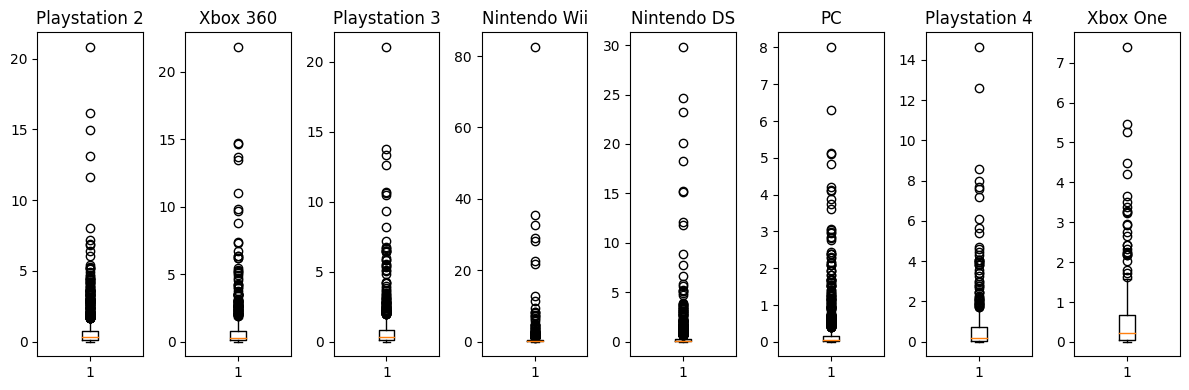

In [10]:
fig, axs = plt.subplots(1, 8, figsize=(12, 4))
axs[0].boxplot(df['total_sales'][df["platform"]=="ps2"])
axs[0].set_title('Playstation 2')
axs[1].boxplot(df['total_sales'][df["platform"]=="x360"])
axs[1].set_title('Xbox 360')
axs[2].boxplot(df['total_sales'][df["platform"]=="ps3"])
axs[2].set_title('Playstation 3')
axs[3].boxplot(df['total_sales'][df["platform"]=="wii"])
axs[3].set_title('Nintendo Wii')
axs[4].boxplot(df['total_sales'][df["platform"]=="ds"])
axs[4].set_title('Nintendo DS')
axs[5].boxplot(df['total_sales'][df["platform"]=="pc"])
axs[5].set_title('PC')
axs[6].boxplot(df['total_sales'][df["platform"]=="ps4"])
axs[6].set_title('Playstation 4')
axs[7].boxplot(df['total_sales'][df["platform"]=="xone"])
axs[7].set_title('Xbox One')
plt.tight_layout()
plt.show()

**En base a los diagramas de cajas arriba mostrados, podemos observar que consolas como Playstation 2, Xbox 360 y Playstarion 3, tienen valores simiares, inclsuive en ventas totales de un juego con alredor de 20M dlls. Podemos observar también una venta de 80M dlls. También podemos concluir que en promedio es normal que no todos los videojuegos tengan un gran volumen de ventas y en promedio no todos los juegos venden mas de 1M o 2M de dlls.**

Mira cómo las reseñas de usuarios y profesionales afectan las ventas de una plataforma popular (tu elección). Crea un gráfico de dispersión y calcula la correlación entre las reseñas y las ventas. Saca conclusiones.

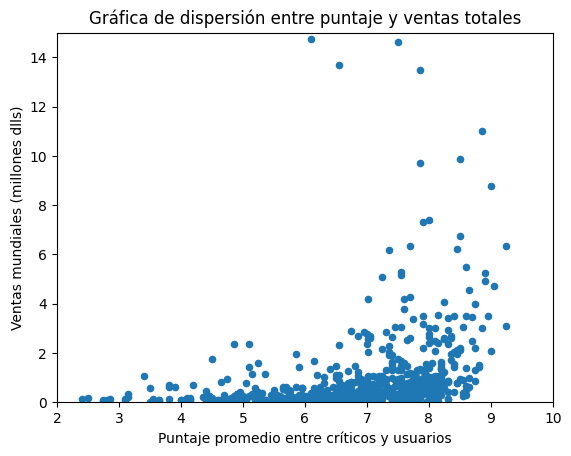

0.2684079000060354


In [11]:
df_xbox360 = df[df["platform"]=="x360"][["name","platform","critic_score","user_score","total_sales"]]
df_xbox360["avg_score"] = (df_xbox360["critic_score"] + df_xbox360["user_score"]) / 2
 
df_xbox360.plot(x="avg_score",
                y="total_sales",
                xlabel="Puntaje promedio entre críticos y usuarios",
                ylabel="Ventas mundiales (millones dlls)",
                kind="scatter",
                title="Gráfica de dispersión entre puntaje y ventas totales",
                xlim=[2,10],
                ylim=[0,15],)
plt.show()

print(df_xbox360["avg_score"].corr(df_xbox360["total_sales"]))

**Elegí la consola xbox 360 y tanto en la gráfica como en el método "corr" podemos ver una muy débil correlación entre la puntuación promedio de los críticos y los usuarios y las ventas totales.**

Teniendo en cuenta tus conclusiones compara las ventas de los mismos juegos en otras plataformas.

In [12]:
multiplatform_games = df.groupby(by="name")["platform"].nunique().reset_index()
multiplatform_games = multiplatform_games[multiplatform_games["platform"]>=3]
multiplatform_games = multiplatform_games["name"].tolist()
df_multi_games = df[(df["name"].isin(multiplatform_games)) & (df["platform"].isin(top_platforms))]
df_multi_games = df_multi_games.groupby(by="name")["total_sales"].sum().reset_index()
print("Top 10 de videojuegos multiplataforma")
print(df_multi_games.sort_values(by="total_sales",ascending=False).head(10))

Top 10 de videojuegos multiplataforma
                               name  total_sales
52          call of duty: black ops        29.20
56   call of duty: modern warfare 3        28.06
53       call of duty: black ops ii        27.47
55   call of duty: modern warfare 2        24.08
135             grand theft auto iv        21.50
136              grand theft auto v        21.05
137   grand theft auto: san andreas        20.92
57       call of duty: world at war        15.59
341     the elder scrolls v: skyrim        15.19
29                    battlefield 3        14.49


**Elegí todos los títulos que al menos se hayan lanzado en 3 o más consolas, al parecer los Call Of Duty, GTA y algunos otros shooters son los juegos más populares de los últimos tiempos.**

Echa un vistazo a la distribución general de los juegos por género. ¿Qué se puede decir de los géneros más rentables? ¿Puedes generalizar acerca de los géneros con ventas altas y bajas?

In [13]:
df_by_genre = df.groupby("genre")["total_sales"].sum().sort_values(ascending=False)
print(df_by_genre)

genre
action          1007.79
sports           788.69
shooter          672.40
misc             490.26
role-playing     396.72
racing           351.12
simulation       263.88
platform         252.83
fighting         180.47
adventure        115.63
puzzle            97.82
strategy          85.42
Name: total_sales, dtype: float64


**Podemos observar que los juegps de acción, deportes y shooter son los 3 más populares entre los usuarios. Si bien en el último top aparecen en su mayoría videojuegos shooters, esto se debe a que el último top está filtrado por juegos multiplataforma. Podemos saber con una simple búsqueda que los juegos de acción más populares son juegos como Grand Theft Auto V, San Andreas y Vice City**

# Paso 4. Crea un perfil de usuario para cada región.

Para cada región (NA, UE, JP) determina:

Las cinco plataformas principales. Describe las variaciones en sus cuotas de mercado de una región a otra.

In [14]:
df_na = df.groupby("platform")["na_sales"].sum().sort_values(ascending=False)
print(f'Top 5 plataformas en Norte América: \n{df_na.head()} \n')

df_eu = df.groupby("platform")["eu_sales"].sum().sort_values(ascending=False)
print(f'Top 5 plataformas en Europa: \n{df_eu.head()} \n')

df_jp = df.groupby("platform")["jp_sales"].sum().sort_values(ascending=False)
print(f'Top 5 plataformas en Japón: \n{df_jp.head()}')

Top 5 plataformas en Norte América: 
platform
ps2     452.87
wii     448.34
x360    415.76
ds      355.21
ps3     330.44
Name: na_sales, dtype: float64 

Top 5 plataformas en Europa: 
platform
ps2     282.37
ps3     271.27
wii     232.61
x360    194.80
ds      175.72
Name: eu_sales, dtype: float64 

Top 5 plataformas en Japón: 
platform
ds     163.86
ps2     94.40
ps3     63.67
wii     60.36
ps4     15.96
Name: jp_sales, dtype: float64


**Si bien en las 3 regiones pareciera haber un comportamiento muy similar entre las consolas más populares, podemos ver que en Japón no consumen mucho el contenido de Microsoft, ya que ni la xbox, xbox 360 o xbox one aparecen en el top de las 5 más populares, caso contrario a NA y EU que si bien no es la más popular, aparece en el top 5 en ambas regiones.**

Los cinco géneros principales. Explica la diferencia.

In [15]:
df_genre_na = df.groupby("genre")["na_sales"].sum().sort_values(ascending=False)
print(f'Top 5 géneros en Norte América: \n{df_genre_na.head()} \n')

df_genre_eu = df.groupby("genre")["eu_sales"].sum().sort_values(ascending=False)
print(f'Top 5 géneros en Europa: \n{df_genre_eu.head()} \n')

df_genre_jp = df.groupby("genre")["jp_sales"].sum().sort_values(ascending=False)
print(f'Top 5 géneros en Japón: \n{df_genre_jp.head()}')

Top 5 géneros en Norte América: 
genre
action          486.91
sports          400.12
shooter         348.87
misc            251.26
role-playing    162.36
Name: na_sales, dtype: float64 

Top 5 géneros en Europa: 
genre
action     329.75
sports     257.81
shooter    229.67
misc       137.93
racing     128.56
Name: eu_sales, dtype: float64 

Top 5 géneros en Japón: 
genre
role-playing    98.30
action          65.81
misc            55.68
sports          44.64
platform        26.32
Name: jp_sales, dtype: float64


**Podemos ver que los géneros que más son rentables en NA y EU son los mismos que dominan el top general, como juegos de acción, deportes y shooters. Mientras que en Japón los géneros más populares son de juego de rol, acción y misc, que son juegos como Fallout, Minecraft, Sims, etc**

Si las clasificaciones de ESRB afectan a las ventas en regiones individuales.

In [16]:
df_esrb_na = df.groupby("rating")["na_sales"].sum().sort_values(ascending=False)
print(f'Top 3 clasificaciones de juegos en Norte América: \n{df_esrb_na.head(3)} \n')

df_esrb_eu = df.groupby("rating")["eu_sales"].sum().sort_values(ascending=False)
print(f'Top 3 clasificaciones de juegos en Europa: \n{df_esrb_eu.head(3)} \n')

df_esrb_jp = df.groupby("rating")["jp_sales"].sum().sort_values(ascending=False)
print(f'Top 3 clasificaciones de juegos en Japón: \n{df_esrb_jp.head(3)}')

Top 3 clasificaciones de juegos en Norte América: 
rating
E    829.80
M    551.05
T    446.68
Name: na_sales, dtype: float64 

Top 3 clasificaciones de juegos en Europa: 
rating
E    493.89
M    390.16
T    285.97
Name: eu_sales, dtype: float64 

Top 3 clasificaciones de juegos en Japón: 
rating
NR    146.23
E     118.28
T      71.52
Name: jp_sales, dtype: float64


**Podemos observar que los patrones en NA y EU se repiten ya que los 3 clasificaciones más consumidas en estas regiones son E (Everybody), M (Mature) y T (Teen). Mientras que en Japón dominan los juegos no clasificacos y para niños y adolescentes.**

# Paso 5. Prueba las siguientes hipótesis.

Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

Explica: Cómo formulaste las hipótesis nula y alternativa y qué criterio utilizaste para probar las hipótesis y por qué.

In [17]:
# Primero voy a crear 2 datafrmes con solo los nombres, plataformas a analizar y sus puntuaciones
# según los usuarios. 
    
df_score_xone = df[df["platform"]=="xone"]["user_score"]
df_score_pc = df[df["platform"]=="pc"]["user_score"]

# La hipótesis nula es que las calificaciones promedios de los usuarios son iguales entre Xbox One 
# y PC. La hipótesis alternativa es que son distintas. Para lo cual una prubea de dos colas puede 
# ser la apropiada para éste estudio. Para saber si el parámetro equal_var será False o True usaré 
# el método levene

beta = 0.05
w_stats, p_value = levene(df_score_xone,df_score_pc)
if p_value < beta:
    variable = False
else:
    variable = True

# Ahora utilizaré el método ttest_ind para probar si mi hipótesis de 2 las clasificaciones entre 
# Xbox One y PC son iguales. 

alpha = 0.05
results = st.ttest_ind(df_score_xone,df_score_pc,equal_var=variable)

if results.pvalue < alpha:
    print("Se rechaza la hipótesis nula")
else:
    print("No podemor rechazar la hipótesis nula")

Se rechaza la hipótesis nula


**Con el estudio estadístico anterior y con el resultado de la hipóteis nula rechazada, podemos concluir que las calificaciones promedio de los usuarios entre Xbox One y PC no son iguales y son distintas unas de otras.**

Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

Explica: Cómo formulaste las hipótesis nula y alternativa y qué criterio utilizaste para probar las hipótesis y por qué.

In [18]:
# Primero voy a crear 2 datafrmes con solo los géneros de acción y deportes según los usuarios. 
    
df_score_action = df[df["genre"]=="action"]["user_score"]
df_score_sports = df[df["genre"]=="sports"]["user_score"]

# La hipótesis nula es que las calificaciones promedios de los géneros acción y deportes son iguales. 
# La hipótesis alternativa es que son distintas. Para lo cual una prubea de dos colas puede ser la 
# apropiada para éste estudio. Para saber si el parámetro equal_var será False o True usaré el método 
# levene

beta = 0.05
w_stats, p_value = levene(df_score_action,df_score_sports)
if p_value < beta:
    variable = False
else:
    variable = True

# Ahora utilizaré el método ttest_ind para probar si mi hipótesis de 2 las clasificaciones entre 
# los géneros action y sports son iguales. 

alpha = 0.05
results = st.ttest_ind(df_score_action,df_score_sports,equal_var=variable)

if results.pvalue < alpha:
    print("Se rechaza la hipótesis nula")
else:
    print("No podemor rechazar la hipótesis nula")

Se rechaza la hipótesis nula


**Con el estudio estadístico anterior y con el resultado de la hipóteis nula rechazada, podemos concluir que las calificaciones promedio de los usuarios entre los géneros de acción y deportes si son distintas unas de otras.**

# Conclusión general.

**Como conclusión general y con el fin de una mejor planeción para las ventas del próximo año 2017, podemos establecer que las mejores consolas para seguir promocionando el siguiente año son: PS2, PS3, PS4, Xbox 360, Xbox One, Nintendo Wii, Nintendo DS y PC, también obtuvimos de los datos que los juegos con mayor número de ventas son las sagas de Call Of Duty y Grand Theft Auto, sin olvidar que también los juegos de deportes son populares.**